### Gender Classification

In this tutorial, we are going to fine-tune the pre-trained VGG-Face descriptors for the task of classifying the gender of a person from his/her face image. As we saw in the previous tutorial, the VGG-Face network has been trained to recognize 2,622 celebrity IDs. Also, we can ignore/chop-off the classification layer of the network and treat the output of the fc-layer as a representation for the input face. We are going to learn a new Softmax  classification layer on top of these fc layer features and train it to classify the gender of the input face image into one of the two classes -- "male" and "female". By the end of this tutorial, the participants would appreciiate the fact that by minimal amount of fine-tuning, the pre-trained VGG-Face representations can be made useful for a variety of tasks that are different from the original task that the representations were learnt from i.e. face recognition.

In [1]:
import cv2, math
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.serialization import load_lua
from torch.legacy import nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 
plt.ion()

For ease-of-use, we have consolidated all the input image pre-processing related steps into a single function that is defined below. 

In [2]:
# The code to load and pre-process image for VGG-Face

def loadImage(imgPath):
    inputImg = cv2.imread(imgPath)

    # re-scale the smaller dim (among width, height) to refSize
    refSize, targetSize = 256, 224
    imgRows, imgCols = inputImg.shape[0], inputImg.shape[1]
    if imgCols < imgRows: resizedImg = cv2.resize(inputImg, (refSize, refSize * imgRows / imgCols))
    else: resizedImg = cv2.resize(inputImg, (refSize * imgCols / imgRows, refSize))

    # center-crop
    oH, oW = targetSize, targetSize
    iH, iW = resizedImg.shape[0], resizedImg.shape[1]
    anchorH, anchorW = int(math.ceil((iH - oH)/2)), int(math.ceil((iW - oW) / 2))
    croppedImg = resizedImg[anchorH:anchorH+oH, anchorW:anchorW+oW]

    # convert shape from (height, width, 3) to (3, width, height)
    channel_1, channel_2, channel_3 = croppedImg[:, :, 0], croppedImg[:, :, 1], croppedImg[:, :, 2]
    croppedImg = np.empty([3, croppedImg.shape[0], croppedImg.shape[1]])
    croppedImg[0], croppedImg[1], croppedImg[2] = channel_1, channel_2, channel_3

    # subtract training mean
    inputImg = inputImg.astype(float)
    trainingMean = [129.1863, 104.7624, 93.5940]
    for i in range(3): croppedImg[i] = croppedImg[i] - trainingMean[i]
    return croppedImg

Similarly, the code that returns the pre-trained VGG-Face descriptors for a set of input images has also been put together inside another function.

In [26]:
# Function to compute pre-trained VGG-Face descriptors 

def getVggFeatures(imgPaths, preTrainedNet):
    nImgs = len(imgPaths)
    preTrainedNet.modules[31] = nn.View(nImgs, 25088)
    preTrainedNet = preTrainedNet.cuda()
    
    batchInput = torch.Tensor(nImgs, 3, 224, 224)
    for i in range(nImgs): batchInput[i] = torch.from_numpy(loadImage(imgPaths[i]))
    
    batchOutput = preTrainedNet.forward(batchInput.cuda())
    return preTrainedNet.modules[35].output.cpu()

### Network Architecture
Having defined the functions for pre-processing images and getting the pre-trained face descriptors, let us take a look at the network structure that we are going to train.

In [27]:
# Network structure that we'll train for gender classification

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(4096, 2)
        self.softmax = torch.nn.LogSoftmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.softmax(x)
        return x 
    
net = Net()
print net

Net (
  (fc1): Linear (4096 -> 2)
  (softmax): LogSoftmax ()
)


The architecture is quite straightforward. We have one ```Linear(4096, 2)``` layer (fc-layer) which takes a 4096-d input and computes a vector that has two elements. Recall from the previous tutorial that the pre-trained VGG-Face descriptors are 4096-d in size. So, our fc-layer can take the pre-trained descriptors as input and return a pair of values which would be the (unnormalized) likelihoods of the input image belonging to each of the two classes -- "male" and "female".

The fc-layer is followed by a ```LogSoftMax()``` layer which converts the unnormalized likelihoods returned by  the fc-layer into log-probabilities which would then be sent to our loss module. By training the parameters of the fc-layer to minimize the loss, our network will learn to map the pre-trained face descriptors to the correct gender class.

### Dataset
We are going to use a subset of the CelebA dataset for our experiment. CelebA is a large-scale celebrity face attributes dataset. It consists of more than 200k celebrity face images, each having 40 binary face attribute annotations, with gender being one of them. We have selected a random subset of 200 face images -- 100 male and female faces each for the purpose of this experiment. Let us take a look at the distribution of the training and test splits.

In [28]:
dataset = load_lua("../../data/lab3/Experiment_2/celeba-gender-dataset.t7")
print "# images in trainset = ", dataset['trainset'].size
print "# images in testset = ", dataset['testset'].size

# images in trainset =  160
# images in testset =  40


Let us take a look at some of the faces in the dataset, and their asosciated labels.

label =  1


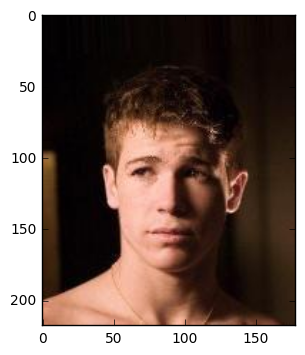

In [29]:
imgPath = "../../data/lab3/Experiment_2/" + dataset['trainset'].imgPaths[0]
imgLabel = dataset['trainset'].labels[0]

print "label = ", imgLabel
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)

`label=0` stands for "male" whereas `label=1` stands for female. Let us also take a look at an example of a female face image in our training set.

label =  0


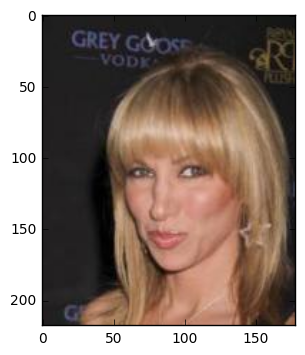

In [30]:
imgPath = "../../data/lab3/Experiment_2/" + dataset['trainset'].imgPaths[100]
imgLabel = dataset['trainset'].labels[100]

print "label = ", imgLabel
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)

We have 160 training and 40 test images with each set having an equal distribution of male and female faces. Participants are encouraged to modify the code and view some of the different face images (and their asosciated labels) in the training as well as test sets.

### Training
Now that we have fixed the network architecture as well as the dataset, let us move on to training our network on the dataset. We are going to use a combination of `LogSoftMax` + `NLLLoss` in PyTorch to train the network. Let us take a look at the various steps involved.

First of all, we fix the seed of the various random number generators that our code uses. Why do we need to do this? So that, all are experimental results are reproducible. Having fixed the seed, our network parameters will always be initialized with the same random values every time we run the experiments. Also, the sampling of the mini-batch during training will also follow the same order in different runs of the experiment. You can verify this fact by commenting out the 2 lines given below and comparing the value of the training loss in successive runs of the experiment.

In [31]:
# fix the seeds of random number generators
torch.manual_seed(0)
np.random.seed(0)

Next, we load the pre-trained VGG-Face model and dataset. We also initialize our network architecture, loss module and certain other training parameters such as number of epochs to train and the batch size.

In [32]:
# load the dataset and the pre-trained network
vggFace = load_lua("../../data/lab3/VGG_FACE_pyTorch_small.t7")
dataset = load_lua("../../data/lab3/Experiment_2/celeba-gender-dataset.t7")

# initialize the net, loss and optimizer (SGD)
net = Net()
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00005, momentum=0.9, weight_decay=0.0005)
nEpochs, batchSize = 1, 10

net = net.cuda()
criterion = criterion.cuda()

Before we jump into the training code, we would first define a function that lets us evaluate how good our model is performing on the test dataset.

In [33]:
# define a function to test the performance of our model on a separate test set
def evaluate(net, dataset):
    correctPreds = 0.0
    for startIdx in range(0, dataset['testset'].size, batchSize):
        endIdx = min(startIdx + batchSize - 1, dataset['testset'].size - 1)
        size = (endIdx - startIdx + 1)
        
        batchInput, batchLabel = torch.Tensor(size, 4096), torch.LongTensor(size)
        batchImgPaths = []
        for offset in range(size):
            imgPath = "../../data/lab3/Experiment_2/" + dataset['testset'].imgPaths[startIdx+offset]
            batchImgPaths.append(imgPath)
            label = dataset['testset'].labels[startIdx+offset]
            batchLabel[offset] = int(label)
        
        batchInput = getVggFeatures(batchImgPaths, vggFace)
        batchInput = Variable(batchInput)

        batchOutput = net(batchInput.cuda())
        batchOutput, batchLabel = batchOutput.data.cpu().numpy(), batchLabel.numpy()
        predictions = np.argmax(batchOutput, 1)
        correctPreds += np.sum(predictions == batchLabel)
    return correctPreds / dataset['testset'].size

Let us see the performance of our (un-trained) network on the test set by calling the `evaluate()` function.

In [34]:
print "accuracy (before training) = ", evaluate(net, dataset)

accuracy (before training) =  0.65


As you can see, the overall classification accuracies are quite low. At the moment, the network is performing only slightly better than a random assignment of classes. This is to be expected because the parameters of the network are randomly initialized and no training has been done till now.

Let us see the code for training the network now.

In [35]:
# start training

for epochCtr in range(nEpochs):
    
    shuffle = np.random.permutation(dataset['trainset'].size)
    runningLoss, iterCnt = 0.0, 0
    for startIdx in range(0, dataset['trainset'].size, batchSize):
        endIdx = min(startIdx + batchSize - 1, dataset['trainset'].size-1)
        size = (endIdx - startIdx + 1)
    
        batchInput, batchLabel = torch.Tensor(size, 4096), torch.LongTensor(size)
        batchImgPaths = []
        for offset in range(size):
            imgPath = "../../data/lab3/Experiment_2/" + dataset['trainset'].imgPaths[shuffle[startIdx+offset]]
            batchImgPaths.append(imgPath)
            label = dataset['trainset'].labels[shuffle[startIdx+offset]]
            batchLabel[offset] = int(label) 
        
        batchInput = getVggFeatures(batchImgPaths, vggFace)
        batchInput = Variable(batchInput)
        batchLabel = Variable(batchLabel)
        batchOutput = net(batchInput.cuda())
        loss = criterion(batchOutput, batchLabel.cuda())
        loss.backward()
        optimizer.step()

        runningLoss += loss.data[0]
        iterCnt += 1
        if iterCnt % 4 == 0:
            print "epoch=", (epochCtr+1), "/", nEpochs, ", iter=", iterCnt, ", loss=", runningLoss/4
            runningLoss = 0.0


epoch= 1 / 1 , iter= 4 , loss= 0.949782863259
epoch= 1 / 1 , iter= 8 , loss= 0.796262532473
epoch= 1 / 1 , iter= 12 , loss= 0.672116458416
epoch= 1 / 1 , iter= 16 , loss= 0.123173894361


Having trained the network, let us see if the performance on the test set has improved over what we got prior to training. 

In [36]:
print "accuracy (after training) = ", evaluate(net, dataset)

accuracy (after training) =  0.95


As you can see, there is a significant jump in performance after training for just 1 epoch (16 iterations).

Let us see our network in action as it classifies individual images from the test set. Recall that `label=1` denotes "male" whereas `label=0` denotes female.

true label =  1
predicted label =  1


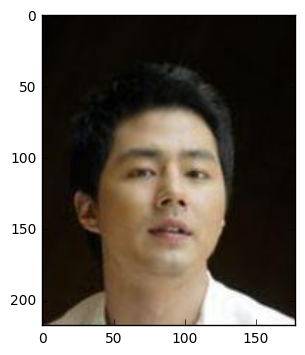

In [37]:
imgPath = "../../data/lab3/Experiment_2/" + dataset['testset'].imgPaths[0]
dispImg = mpimg.imread(imgPath)
imgPlot = plt.imshow(dispImg)
imgLabel = dataset['testset'].labels[0]
print "true label = ", imgLabel

features = getVggFeatures([imgPath], vggFace)
output = net(Variable(features).cuda()).data.cpu().numpy()
print "predicted label = ", np.argmax(output, 1)[0]